# Wczytywanie danych

In [1]:
import torch
from torch_geometric.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'device')

# Wczytaj zbiór uczący
train_dataset = torch.load('us26_train_dataset_big.pt')
# wczytaj zbiór testowy
test_dataset = torch.load('us26_test_dataset_big.pt')

print(len(train_dataset))
print(len(test_dataset))

# Definiuj DataLoader dla zbiorów uczącego i testowego
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

1839
460


/home/franek/anaconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# ChGW0

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv

class GraphRegressionModel(nn.Module):
    def __init__(self, num_node_features=1, hidden_dim=64, output_dim=1, dropout=0.5, momentum=0.5):
        super(GraphRegressionModel, self).__init__()
        name = 'ChGW0'

        # Graph Convolutional Layer
        self.conv1 = GraphConv(num_node_features, hidden_dim)

        # Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(hidden_dim + 2, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # Store momentum as an attribute
        self.momentum = momentum
        
    def forward(self, data):
        x, edge_index, edge_weight, global_feature = data.x, data.edge_index, data.edge_weight, data.global_feature

        # Apply Graph Convolution
        x = self.conv1(x, edge_index, edge_weight=edge_weight)

        # Global features concatenation
        global_feature = global_feature.expand(x.size(0), -1)  # Dostosuj global_feature do rozmiaru x
        x = torch.cat([x, global_feature], dim=1)

        # Fully Connected Layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
    def loss(self, pred, score):
        return F.mse_loss(pred, score)

# testy

In [3]:
from sklearn.metrics import r2_score
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np



# Define the hyperparameter values to test
hidden_dim_values = list(range(64, 256, 64))
dropout_values = np.arange(0.1, 1.0, 0.2)
momentum_values = np.arange(0.1, 1.0, 0.2)

# Initialize a dictionary to store results
part_results ={}
results = {}

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over hyperparameters
for hidden_dim in hidden_dim_values:
    for dropout in dropout_values:
        for momentum in momentum_values:
            print(f"\nTesting for hidden_dim={hidden_dim}, dropout={dropout}, momentum={momentum}")

            # Initialize a dictionary to store results for the current hyperparameters
            hyperparam_results = {'MSE': [], 'R2': []}

            # Loop over folds
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                train_data = [train_dataset[i] for i in train_idx]
                val_data = [train_dataset[i] for i in val_idx]

                model = GraphRegressionModel(num_node_features=1, hidden_dim=hidden_dim, output_dim=1, dropout=dropout, momentum=momentum)
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Training loop
                model.train()
                for epoch in tqdm(range(50), desc=f"Fold {fold + 1}/{num_folds}"):
                    for data in train_data:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = model.loss(output, data.y.view(-1, 1).float())
                        loss.backward()
                        optimizer.step()

                # Validation loop
                model.eval()
                y_true = []
                y_pred = []
                
                for data in val_data:
                    with torch.no_grad():    
                        output = model(data)[0][0].item()                
                        y_pred.append(output)

                    y_true.append(data.y.item())

                # Calculate and store Mean Squared Error (MSE)
                r2 = r2_score(y_true, y_pred)
                hyperparam_results['R2'].append(r2)
                mse = mean_squared_error(y_true, y_pred)
                hyperparam_results['MSE'].append(mse)
                part_results[(hidden_dim, dropout, momentum, fold)] = {'MSE': mse, 'R2' : r2}

                with open('chkgw0_spec_big_us26.txt', 'a') as file2:
                    file2.write("\n")
                    file2.write(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Fold: {fold}, MSE: {mse}, R2: {r2}")
            # Calculate average MSE across folds
            avg_mse = sum(hyperparam_results['MSE']) / num_folds
            avg_r2 = sum(hyperparam_results['R2']) / num_folds
            results[(hidden_dim, dropout, momentum)] = {'Avg MSE': avg_mse, 'Avg R2': avg_r2}
            with open('chkgw0_avg_big_us26.txt', 'a') as file1:
                file1.write("\n")
                file1.write(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Avg MSE: {avg_mse}, Avg R2: {avg_r2}")






Testing for hidden_dim=64, dropout=0.1, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.1, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.1, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.1, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.1, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.30000000000000004, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.30000000000000004, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.30000000000000004, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.30000000000000004, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.30000000000000004, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.5000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.5000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.5000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.5000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.5000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.7000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.7000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.7000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.7000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.7000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.9000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.9000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.9000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.9000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=64, dropout=0.9000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.1, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.1, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.1, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.1, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.1, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.30000000000000004, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.30000000000000004, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.30000000000000004, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.30000000000000004, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.30000000000000004, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.5000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.5000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.5000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.5000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.5000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.7000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.7000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.7000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.7000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.7000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.9000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.9000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.9000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.9000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=128, dropout=0.9000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.1, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.1, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.1, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.1, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.1, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.30000000000000004, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.30000000000000004, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.30000000000000004, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.30000000000000004, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.30000000000000004, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.5000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.5000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.5000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.5000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.5000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.7000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.7000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.7000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.7000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.7000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.9000000000000001, momentum=0.1


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.9000000000000001, momentum=0.30000000000000004


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.9000000000000001, momentum=0.5000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.9000000000000001, momentum=0.7000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr


Testing for hidden_dim=192, dropout=0.9000000000000001, momentum=0.9000000000000001


Fold 1/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 2/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pred, score)
Fold 3/10:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63749/2804048419.py:40: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(pr

# Model podstawowy, ale bez dropout'u - chyba najlepszy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv

class GraphRegressionModel(nn.Module):
    def __init__(self, num_node_features=1, hidden_dim=64, output_dim=1, momentum=0.5):
        super(GraphRegressionModel, self).__init__()

        # Graph Convolutional Layer
        self.conv1 = GraphConv(num_node_features, hidden_dim)

        # Fully Connected Layers (without Dropout)
        self.fc1 = nn.Linear(hidden_dim + 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Store momentum as an attribute
        self.momentum = momentum
    def forward(self, data):
        x, edge_index, edge_weight, global_feature = data.x, data.edge_index, data.edge_weight, data.global_feature

        # Apply Graph Convolution
        x = self.conv1(x, edge_index, edge_weight=edge_weight)

        # Global features concatenation
        global_feature = global_feature.expand(x.size(0), -1)
        x = torch.cat([x, global_feature], dim=1)

        # Fully Connected Layers (without Dropout)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def loss(self, pred, score):
        return F.mse_loss(pred, score)


In [ ]:
from sklearn.metrics import r2_score
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np



# Define the hyperparameter values to test
hidden_dim_values = list(range(16, 512, 16))
momentum_values = np.arange(0.05, 1.0, 0.05)

# Initialize a dictionary to store results
part_results ={}
results = {}

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over hyperparameters
for hidden_dim in hidden_dim_values:
        for momentum in momentum_values:
            print(f"\nTesting for hidden_dim={hidden_dim}, momentum={momentum}")

            # Initialize a dictionary to store results for the current hyperparameters
            hyperparam_results = {'MSE': [], 'R2': []}

            # Loop over folds
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                train_data = [train_dataset[i] for i in train_idx]
                val_data = [train_dataset[i] for i in val_idx]

                model = GraphRegressionModel(num_node_features=1, hidden_dim=hidden_dim, output_dim=1, momentum=momentum)
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Training loop
                model.train()
                for epoch in tqdm(range(10), desc=f"Fold {fold + 1}/{num_folds}"):
                    for data in train_data:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = model.loss(output, data.y.view(-1, 1).float())
                        loss.backward()
                        optimizer.step()

                # Validation loop
                model.eval()
                y_true = []
                y_pred = []
                
                for data in val_data:
                    with torch.no_grad():    
                        output = model(data)[0][0].item()                
                        y_pred.append(output)

                    y_true.append(data.y.item())

                # Calculate and store Mean Squared Error (MSE)
                r2 = r2_score(y_true, y_pred)
                hyperparam_results['R2'].append(r2)
                mse = mean_squared_error(y_true, y_pred)
                hyperparam_results['MSE'].append(mse)
                part_results[(hidden_dim, momentum, fold)] = {'MSE': mse, 'R2' : r2}

            # Calculate average MSE across folds
            avg_mse = sum(hyperparam_results['MSE']) / num_folds
            avg_r2 = sum(hyperparam_results['R2']) / num_folds
            results[(hidden_dim, momentum)] = {'Avg MSE': avg_mse, 'Avg R2': avg_r2}


# Open files for writing
with open('noDrop_avg.txt', 'w') as file1, open('noDrop_spec.txt', 'w') as file2:
    # Print the results to file1
    for (hidden_dim, dropout), metrics in results.items():
        print(f"Hidden Dim: {hidden_dim}, Momentum: {momentum}, Avg MSE: {metrics['Avg MSE']}, Avg R2: {metrics['Avg R2']}", file=file1)

    # Print the partial results to file2
    for (hidden_dim, dropout, fold), metrics in part_results.items():
        print(f"Hidden Dim: {hidden_dim}, Momentum: {momentum}, Fold: {fold}, MSE: {metrics['MSE']}, R2: {metrics['R2']}", file=file2)



# Model podstawowy bez cech globalnych

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv

class GraphRegressionModel(nn.Module):
    def __init__(self, num_node_features=1, hidden_dim=64, output_dim=1, dropout=0.5, momentum=0.5):
        super(GraphRegressionModel, self).__init__()

        # Graph Convolutional Layer
        self.conv1 = GraphConv(num_node_features, hidden_dim)

        # Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Store momentum as an attribute
        self.momentum = momentum
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

        # Apply Graph Convolution
        x = self.conv1(x, edge_index, edge_weight=edge_weight)

        # Fully Connected Layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
    def loss(self, pred, score):
        return F.mse_loss(pred, score)


In [ ]:
from sklearn.metrics import r2_score
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np



# Define the hyperparameter values to test
hidden_dim_values = list(range(16, 512, 16))
dropout_values = np.arange(0.05, 1.0, 0.05)
momentum_values = np.arange(0.05, 1.0, 0.05)

# Initialize a dictionary to store results
part_results ={}
results = {}

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over hyperparameters
for hidden_dim in hidden_dim_values:
    for dropout in dropout_values:
        for momentum in momentum_values:
            print(f"\nTesting for hidden_dim={hidden_dim}, dropout={dropout}, momentum={momentum}")

            # Initialize a dictionary to store results for the current hyperparameters
            hyperparam_results = {'MSE': [], 'R2': []}

            # Loop over folds
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                train_data = [train_dataset[i] for i in train_idx]
                val_data = [train_dataset[i] for i in val_idx]

                model = GraphRegressionModel(num_node_features=1, hidden_dim=hidden_dim, output_dim=1, dropout=dropout, momentum=momentum)
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Training loop
                model.train()
                for epoch in tqdm(range(10), desc=f"Fold {fold + 1}/{num_folds}"):
                    for data in train_data:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = model.loss(output, data.y.view(-1, 1).float())
                        loss.backward()
                        optimizer.step()

                # Validation loop
                model.eval()
                y_true = []
                y_pred = []
                
                for data in val_data:
                    with torch.no_grad():    
                        output = model(data)[0][0].item()                
                        y_pred.append(output)

                    y_true.append(data.y.item())

                # Calculate and store Mean Squared Error (MSE)
                r2 = r2_score(y_true, y_pred)
                hyperparam_results['R2'].append(r2)
                mse = mean_squared_error(y_true, y_pred)
                hyperparam_results['MSE'].append(mse)
                part_results[(hidden_dim, dropout, momentum, fold)] = {'MSE': mse, 'R2' : r2}

            # Calculate average MSE across folds
            avg_mse = sum(hyperparam_results['MSE']) / num_folds
            avg_r2 = sum(hyperparam_results['R2']) / num_folds
            results[(hidden_dim, dropout, momentum)] = {'Avg MSE': avg_mse, 'Avg R2': avg_r2}


# Open files for writing
with open('noGlob_avg.txt', 'w') as file1, open('noGlob_spec.txt', 'w') as file2:
    # Print the results to file1
    for (hidden_dim, dropout), metrics in results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Avg MSE: {metrics['Avg MSE']}, Avg R2: {metrics['Avg R2']}", file=file1)

    # Print the partial results to file2
    for (hidden_dim, dropout, fold), metrics in part_results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Fold: {fold}, MSE: {metrics['MSE']}, R2: {metrics['R2']}", file=file2)



# ChGW1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphRegressionModelGCN(nn.Module):
    def __init__(self, num_node_features=1, hidden_dim=64, output_dim=1, dropout=0.5, momentum=0.5):
        super(GraphRegressionModelGCN, self).__init__()

        # Graph Convolutional Layer using GCNConv
        self.conv1 = GCNConv(num_node_features, hidden_dim)

        # Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(hidden_dim + 2, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Store momentum as an attribute
        self.momentum = momentum
    def forward(self, data):
        x, edge_index, edge_weight, global_feature = data.x, data.edge_index, data.edge_weight, data.global_feature

        # Apply Graph Convolution using GCNConv
        x = self.conv1(x, edge_index, edge_weight=edge_weight)

        # Global features concatenation
        global_feature = global_feature.expand(x.size(0), -1)
        x = torch.cat([x, global_feature], dim=1)

        # Fully Connected Layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
    def loss(self, pred, score):
        return F.mse_loss(pred, score)

In [ ]:
from sklearn.metrics import r2_score
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np



# Define the hyperparameter values to test
hidden_dim_values = list(range(16, 512, 16))
dropout_values = np.arange(0.05, 1.0, 0.05)
momentum_values = np.arange(0.05, 1.0, 0.05)

# Initialize a dictionary to store results
part_results ={}
results = {}

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over hyperparameters
for hidden_dim in hidden_dim_values:
    for dropout in dropout_values:
        for momentum in momentum_values:
            print(f"\nTesting for hidden_dim={hidden_dim}, dropout={dropout}, momentum={momentum}")

            # Initialize a dictionary to store results for the current hyperparameters
            hyperparam_results = {'MSE': [], 'R2': []}

            # Loop over folds
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                train_data = [train_dataset[i] for i in train_idx]
                val_data = [train_dataset[i] for i in val_idx]

                model = GraphRegressionModel(num_node_features=1, hidden_dim=hidden_dim, output_dim=1, dropout=dropout, momentum=momentum)
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Training loop
                model.train()
                for epoch in tqdm(range(10), desc=f"Fold {fold + 1}/{num_folds}"):
                    for data in train_data:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = model.loss(output, data.y.view(-1, 1).float())
                        loss.backward()
                        optimizer.step()

                # Validation loop
                model.eval()
                y_true = []
                y_pred = []
                
                for data in val_data:
                    with torch.no_grad():    
                        output = model(data)[0][0].item()                
                        y_pred.append(output)

                    y_true.append(data.y.item())

                # Calculate and store Mean Squared Error (MSE)
                r2 = r2_score(y_true, y_pred)
                hyperparam_results['R2'].append(r2)
                mse = mean_squared_error(y_true, y_pred)
                hyperparam_results['MSE'].append(mse)
                part_results[(hidden_dim, dropout, momentum, fold)] = {'MSE': mse, 'R2' : r2}

            # Calculate average MSE across folds
            avg_mse = sum(hyperparam_results['MSE']) / num_folds
            avg_r2 = sum(hyperparam_results['R2']) / num_folds
            results[(hidden_dim, dropout, momentum)] = {'Avg MSE': avg_mse, 'Avg R2': avg_r2}


# Open files for writing
with open('chkgw1_avg.txt', 'w') as file1, open('chkgw1_spec.txt', 'w') as file2:
    # Print the results to file1
    for (hidden_dim, dropout), metrics in results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Avg MSE: {metrics['Avg MSE']}, Avg R2: {metrics['Avg R2']}", file=file1)

    # Print the partial results to file2
    for (hidden_dim, dropout, fold), metrics in part_results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Fold: {fold}, MSE: {metrics['MSE']}, R2: {metrics['R2']}", file=file2)



# ChGW2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv

class GraphRegressionModelCheb(nn.Module):
    def __init__(self, num_node_features=1, hidden_dim=64, output_dim=1, dropout=0.5, momentum=0.5):
        super(GraphRegressionModelCheb, self).__init__()

        # Chebyshev Graph Convolutional Layer
        self.conv1 = ChebConv(num_node_features, hidden_dim, K=2)  # K is the filter size (you can adjust it)

        # Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(hidden_dim + 2, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Store momentum as an attribute
        self.momentum = momentum
    def forward(self, data):
        x, edge_index, edge_weight, global_feature = data.x, data.edge_index, data.edge_weight, data.global_feature

        # Apply Chebyshev Graph Convolution
        x = self.conv1(x, edge_index, edge_weight=edge_weight)

        # Global features concatenation
        global_feature = global_feature.expand(x.size(0), -1)
        x = torch.cat([x, global_feature], dim=1)

        # Fully Connected Layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
    def loss(self, pred, score):
        return F.mse_loss(pred, score)

In [ ]:
from sklearn.metrics import r2_score
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np



# Define the hyperparameter values to test
hidden_dim_values = list(range(16, 512, 16))
dropout_values = np.arange(0.05, 1.0, 0.05)
momentum_values = np.arange(0.05, 1.0, 0.05)

# Initialize a dictionary to store results
part_results ={}
results = {}

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over hyperparameters
for hidden_dim in hidden_dim_values:
    for dropout in dropout_values:
        for momentum in momentum_values:
            print(f"\nTesting for hidden_dim={hidden_dim}, dropout={dropout}, momentum={momentum}")

            # Initialize a dictionary to store results for the current hyperparameters
            hyperparam_results = {'MSE': [], 'R2': []}

            # Loop over folds
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                train_data = [train_dataset[i] for i in train_idx]
                val_data = [train_dataset[i] for i in val_idx]

                model = GraphRegressionModel(num_node_features=1, hidden_dim=hidden_dim, output_dim=1, dropout=dropout, momentum=momentum)
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Training loop
                model.train()
                for epoch in tqdm(range(10), desc=f"Fold {fold + 1}/{num_folds}"):
                    for data in train_data:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = model.loss(output, data.y.view(-1, 1).float())
                        loss.backward()
                        optimizer.step()

                # Validation loop
                model.eval()
                y_true = []
                y_pred = []
                
                for data in val_data:
                    with torch.no_grad():    
                        output = model(data)[0][0].item()                
                        y_pred.append(output)

                    y_true.append(data.y.item())

                # Calculate and store Mean Squared Error (MSE)
                r2 = r2_score(y_true, y_pred)
                hyperparam_results['R2'].append(r2)
                mse = mean_squared_error(y_true, y_pred)
                hyperparam_results['MSE'].append(mse)
                part_results[(hidden_dim, dropout, momentum, fold)] = {'MSE': mse, 'R2' : r2}

            # Calculate average MSE across folds
            avg_mse = sum(hyperparam_results['MSE']) / num_folds
            avg_r2 = sum(hyperparam_results['R2']) / num_folds
            results[(hidden_dim, dropout, momentum)] = {'Avg MSE': avg_mse, 'Avg R2': avg_r2}


# Open files for writing
with open('chkgw2_avg.txt', 'w') as file1, open('chkgw2_spec.txt', 'w') as file2:
    # Print the results to file1
    for (hidden_dim, dropout), metrics in results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Avg MSE: {metrics['Avg MSE']}, Avg R2: {metrics['Avg R2']}", file=file1)

    # Print the partial results to file2
    for (hidden_dim, dropout, fold), metrics in part_results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Fold: {fold}, MSE: {metrics['MSE']}, R2: {metrics['R2']}", file=file2)



# EdgeConv

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, EdgeConv

class CustomEdgeConv(nn.Module):
    def __init__(self, num_node_features, hidden_dim):
        super(CustomEdgeConv, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(1, 32),  # Adjust the input size for the first linear layer
            nn.ReLU(),
            nn.Linear(32, hidden_dim)
        ])

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x)
        return x

class GraphRegressionModel(nn.Module):
    def __init__(self, num_node_features=1, hidden_dim=64, output_dim=1, dropout=0.5, momentum=0.5):
        super(GraphRegressionModel, self).__init__()

        # Graph Convolutional Layer
        #self.conv1 = GraphConv(num_node_features, hidden_dim)

        # Edge Convolutional Layer
        self.conv2 = CustomEdgeConv(num_node_features, hidden_dim+2)

        # Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(hidden_dim + 4, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Store momentum as an attribute
        self.momentum = momentum
    def forward(self, data):
        x, edge_index, edge_weight, global_feature = data.x, data.edge_index, data.edge_weight, data.global_feature

        # Apply Graph Convolution
        #x = self.conv1(x, edge_index, edge_weight=edge_weight)
        # Apply Edge Convolution
        x = self.conv2(x, edge_index)

        # Global features concatenation
        global_feature = global_feature.expand(x.size(0), -1)
        x = torch.cat([x, global_feature], dim=1)

        # Fully Connected Layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def loss(self, pred, score):
        return F.mse_loss(pred, score)

In [ ]:
from sklearn.metrics import r2_score
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np



# Define the hyperparameter values to test
hidden_dim_values = list(range(16, 512, 16))
dropout_values = np.arange(0.05, 1.0, 0.05)
momentum_values = np.arange(0.05, 1.0, 0.05)

# Initialize a dictionary to store results
part_results ={}
results = {}

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over hyperparameters
for hidden_dim in hidden_dim_values:
    for dropout in dropout_values:
        for momentum in momentum_values:
            print(f"\nTesting for hidden_dim={hidden_dim}, dropout={dropout}, momentum={momentum}")

            # Initialize a dictionary to store results for the current hyperparameters
            hyperparam_results = {'MSE': [], 'R2': []}

            # Loop over folds
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                train_data = [train_dataset[i] for i in train_idx]
                val_data = [train_dataset[i] for i in val_idx]

                model = GraphRegressionModel(num_node_features=1, hidden_dim=hidden_dim, output_dim=1, dropout=dropout, momentum=momentum)
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Training loop
                model.train()
                for epoch in tqdm(range(10), desc=f"Fold {fold + 1}/{num_folds}"):
                    for data in train_data:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = model.loss(output, data.y.view(-1, 1).float())
                        loss.backward()
                        optimizer.step()

                # Validation loop
                model.eval()
                y_true = []
                y_pred = []
                
                for data in val_data:
                    with torch.no_grad():    
                        output = model(data)[0][0].item()                
                        y_pred.append(output)

                    y_true.append(data.y.item())

                # Calculate and store Mean Squared Error (MSE)
                r2 = r2_score(y_true, y_pred)
                hyperparam_results['R2'].append(r2)
                mse = mean_squared_error(y_true, y_pred)
                hyperparam_results['MSE'].append(mse)
                part_results[(hidden_dim, dropout, momentum, fold)] = {'MSE': mse, 'R2' : r2}

            # Calculate average MSE across folds
            avg_mse = sum(hyperparam_results['MSE']) / num_folds
            avg_r2 = sum(hyperparam_results['R2']) / num_folds
            results[(hidden_dim, dropout, momentum)] = {'Avg MSE': avg_mse, 'Avg R2': avg_r2}


# Open files for writing
with open('edgeConv_avg.txt', 'w') as file1, open('edgeConv_spec.txt', 'w') as file2:
    # Print the results to file1
    for (hidden_dim, dropout), metrics in results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Avg MSE: {metrics['Avg MSE']}, Avg R2: {metrics['Avg R2']}", file=file1)

    # Print the partial results to file2
    for (hidden_dim, dropout, fold), metrics in part_results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Fold: {fold}, MSE: {metrics['MSE']}, R2: {metrics['R2']}", file=file2)



# GCNConv

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
    

class GraphRegressionModel(nn.Module):
    def __init__(self, num_node_features=1, hidden_dim=64, output_dim=1, dropout=0.5, momentum=0.5):
        super(GraphRegressionModel, self).__init__()

        # Graph Convolutional Layer
        self.conv1 = GCNConv(num_node_features, hidden_dim)


        # Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(hidden_dim + 2, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # Store momentum as an attribute
        self.momentum = momentum
    def forward(self, data):
        x, edge_index, edge_weight, global_feature = data.x, data.edge_index, data.edge_weight, data.global_feature

        # Apply Graph Convolution
        x = self.conv1(x, edge_index, edge_weight=edge_weight)


        # Global features concatenation
        global_feature = global_feature.expand(x.size(0), -1)
        x = torch.cat([x, global_feature], dim=1)

        # Fully Connected Layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def loss(self, pred, score):
        return F.mse_loss(pred, score)

In [ ]:
from sklearn.metrics import r2_score
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader
from torch_geometric.data import Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np



# Define the hyperparameter values to test
hidden_dim_values = list(range(16, 512, 16))
dropout_values = np.arange(0.05, 1.0, 0.05)
momentum_values = np.arange(0.05, 1.0, 0.05)

# Initialize a dictionary to store results
part_results ={}
results = {}

# Define the number of folds for cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Loop over hyperparameters
for hidden_dim in hidden_dim_values:
    for dropout in dropout_values:
        for momentum in momentum_values:
            print(f"\nTesting for hidden_dim={hidden_dim}, dropout={dropout}, momentum={momentum}")

            # Initialize a dictionary to store results for the current hyperparameters
            hyperparam_results = {'MSE': [], 'R2': []}

            # Loop over folds
            for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                train_data = [train_dataset[i] for i in train_idx]
                val_data = [train_dataset[i] for i in val_idx]

                model = GraphRegressionModel(num_node_features=1, hidden_dim=hidden_dim, output_dim=1, dropout=dropout, momentum=momentum)
                optimizer = optim.Adam(model.parameters(), lr=0.001)

                # Training loop
                model.train()
                for epoch in tqdm(range(10), desc=f"Fold {fold + 1}/{num_folds}"):
                    for data in train_data:
                        optimizer.zero_grad()
                        output = model(data)
                        loss = model.loss(output, data.y.view(-1, 1).float())
                        loss.backward()
                        optimizer.step()

                # Validation loop
                model.eval()
                y_true = []
                y_pred = []
                
                for data in val_data:
                    with torch.no_grad():    
                        output = model(data)[0][0].item()                
                        y_pred.append(output)

                    y_true.append(data.y.item())

                # Calculate and store Mean Squared Error (MSE)
                r2 = r2_score(y_true, y_pred)
                hyperparam_results['R2'].append(r2)
                mse = mean_squared_error(y_true, y_pred)
                hyperparam_results['MSE'].append(mse)
                part_results[(hidden_dim, dropout, momentum, fold)] = {'MSE': mse, 'R2' : r2}

            # Calculate average MSE across folds
            avg_mse = sum(hyperparam_results['MSE']) / num_folds
            avg_r2 = sum(hyperparam_results['R2']) / num_folds
            results[(hidden_dim, dropout, momentum)] = {'Avg MSE': avg_mse, 'Avg R2': avg_r2}


# Open files for writing
with open('GCN_avg.txt', 'w') as file1, open('GCN_spec.txt', 'w') as file2:
    # Print the results to file1
    for (hidden_dim, dropout), metrics in results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Avg MSE: {metrics['Avg MSE']}, Avg R2: {metrics['Avg R2']}", file=file1)

    # Print the partial results to file2
    for (hidden_dim, dropout, fold), metrics in part_results.items():
        print(f"Hidden Dim: {hidden_dim}, Dropout: {dropout}, Momentum: {momentum}, Fold: {fold}, MSE: {metrics['MSE']}, R2: {metrics['R2']}", file=file2)



# parowy test t-Studenta

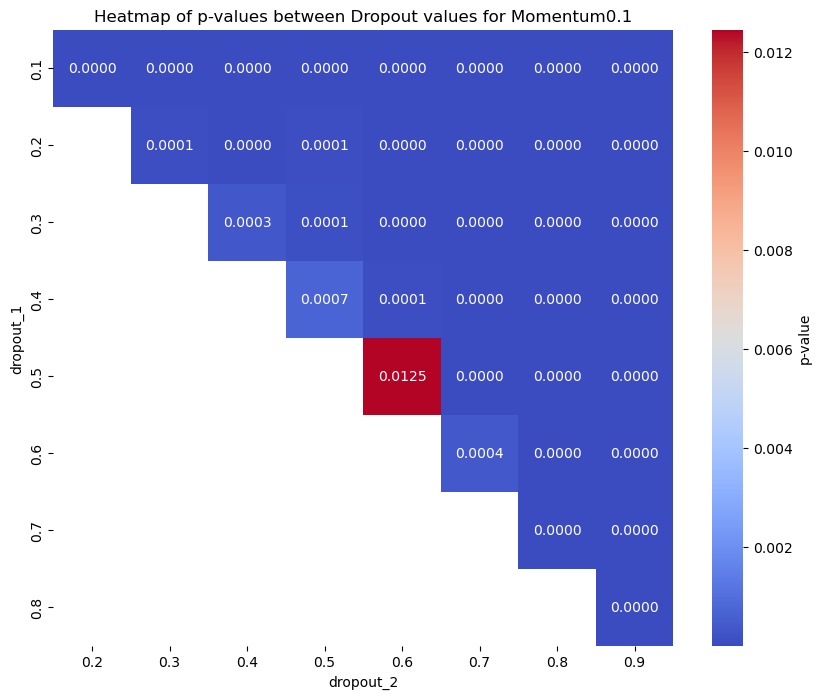

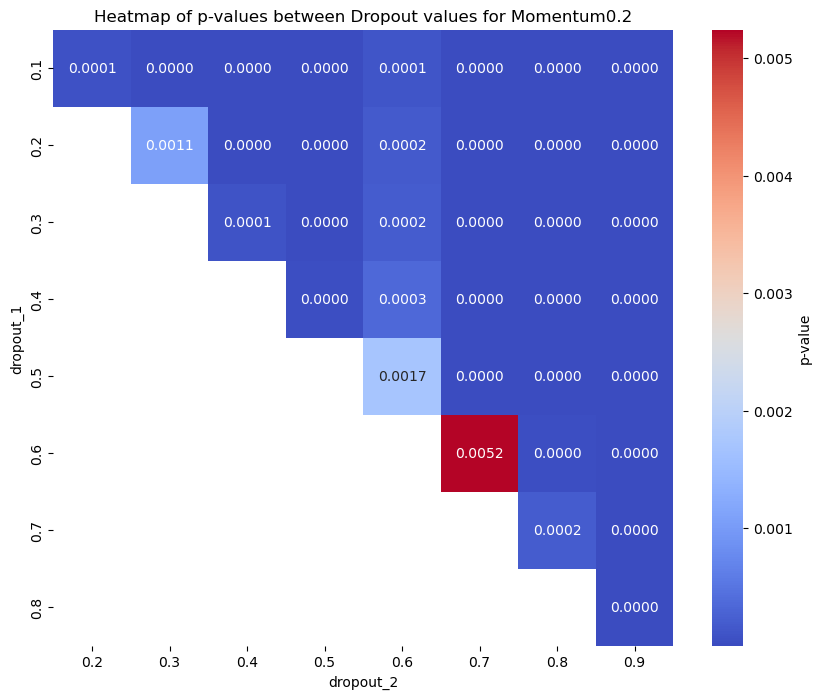

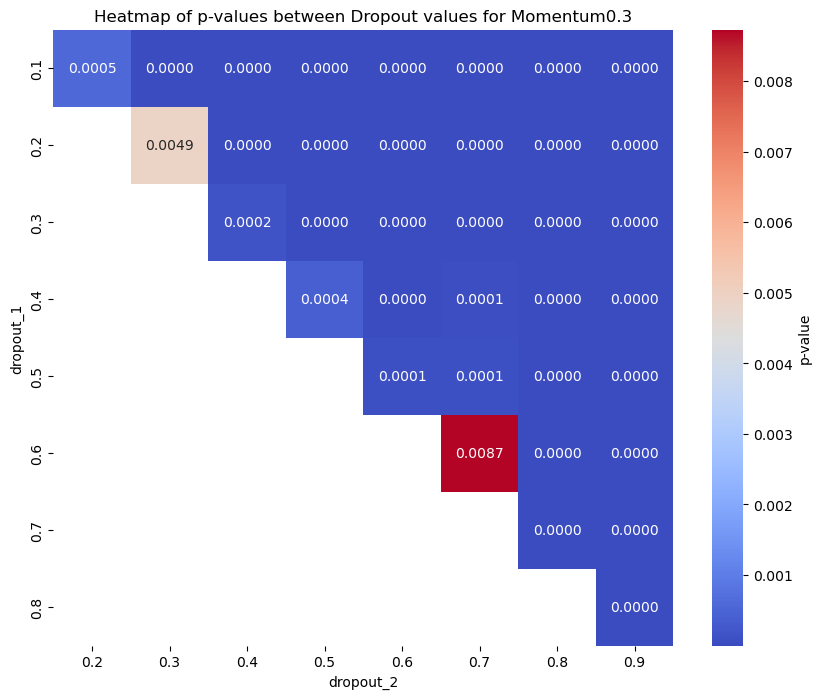

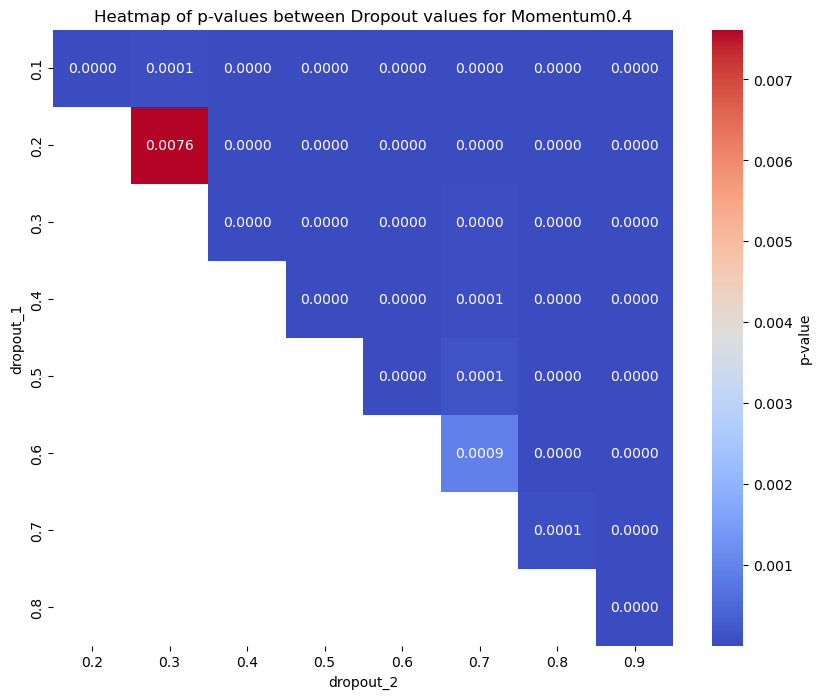

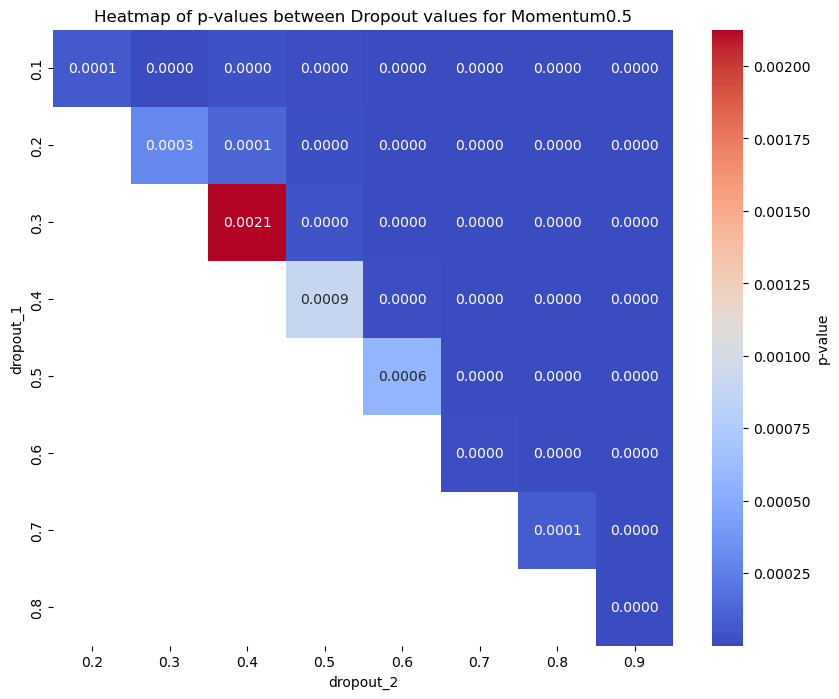

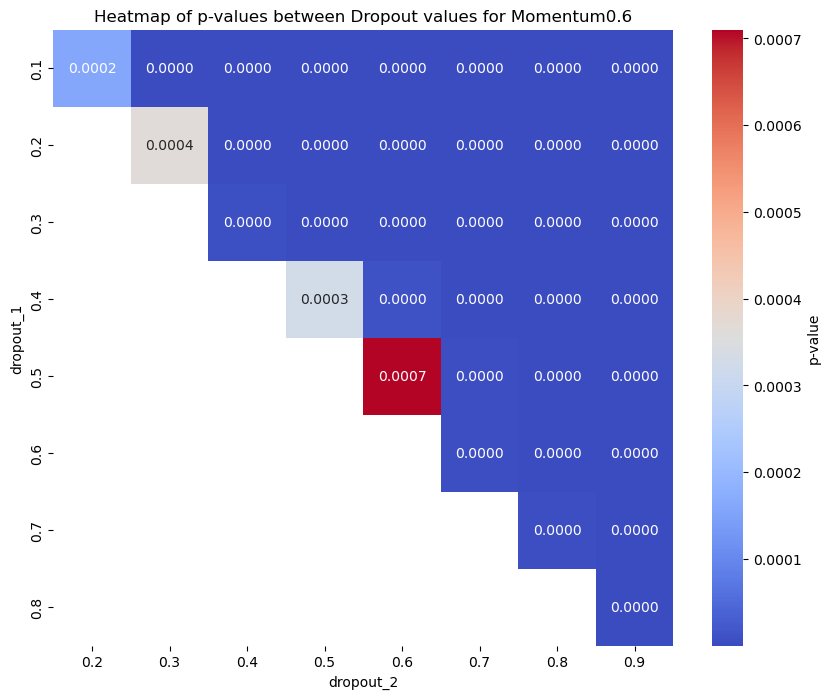

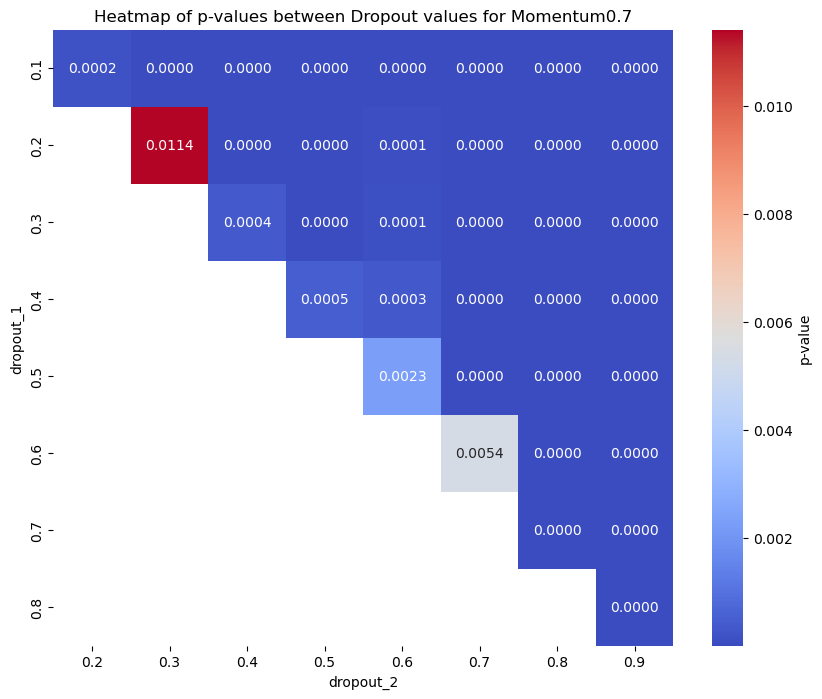

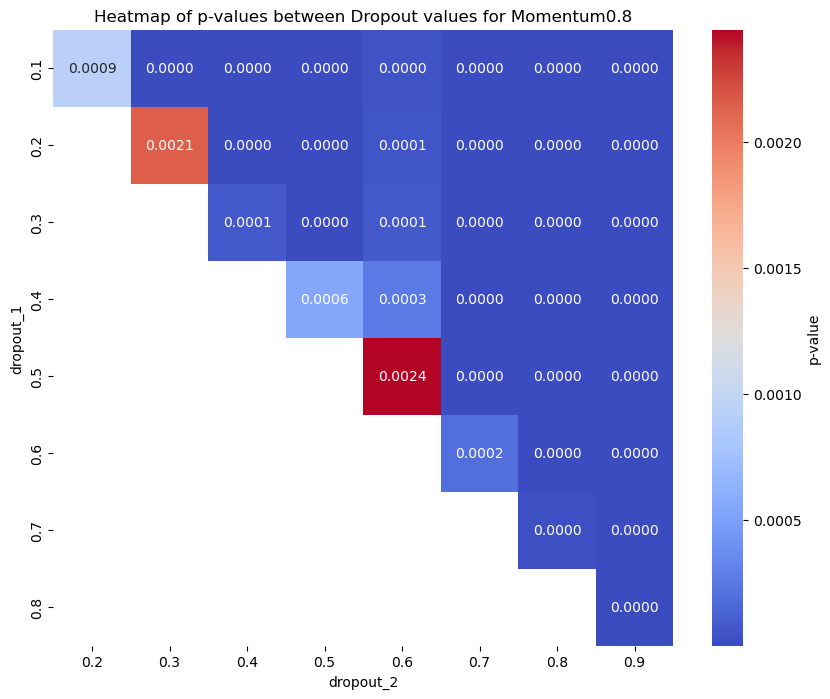

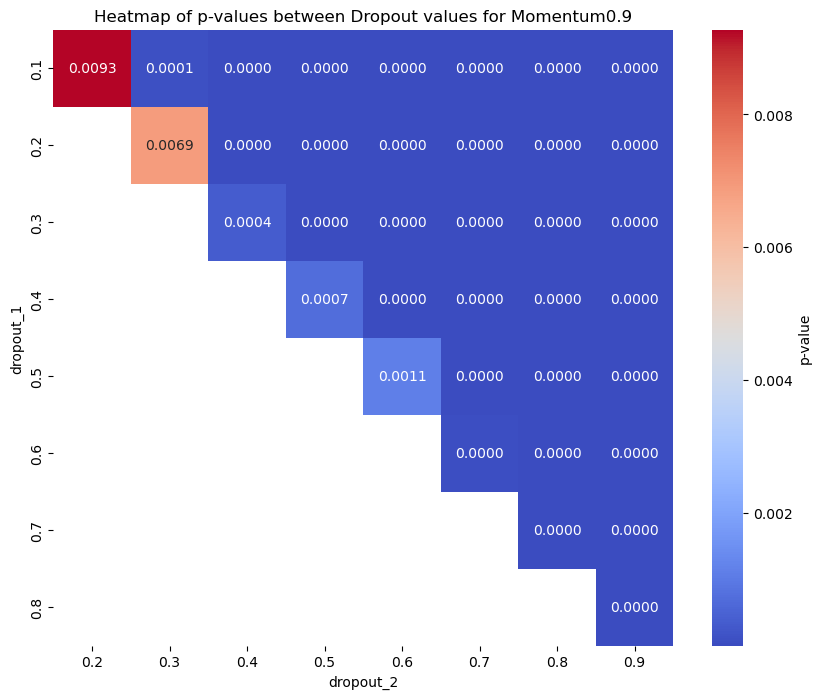

In [54]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



# Read data from file
file_path = "/home/franek/05-12_code/test/data2"
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extract values using regular expressions
data = {'Dropout': [], 'Momentum': [], 'Fold': [], 'R2': []}
for line in lines:
    match = re.match(r"Dropout: (\d+\.\d+) Momentum: (\d+\.\d+) Fold: (\d+\.\d+) R2: (\d+\.\d+)", line)
    if match:
        data['Dropout'].append(float(match.group(1)))
        data['Momentum'].append(float(match.group(2)))
        data['Fold'].append(float(match.group(3)))
        data['R2'].append(float(match.group(4)))

# Create a DataFrame from the extracted data
df = pd.DataFrame(data)
for dropVal in (0.100, 0.200, 0.300, 0.400, 0.500, 0.600, 0.700, 0.800, 0.900):
    # Filter data for cases where 'Dropout' is 0.9
    df_filtered = df[df['Momentum'] == dropVal]

    # Iterate through unique momentum values in the filtered data
    momentum_values = df_filtered['Dropout'].unique()

    # Initialize lists to store t-test results
    t_test_results = []

    # Perform pairwise t-test for each pair of momentum values
    for i in range(len(momentum_values) - 1):
        for j in range(i + 1, len(momentum_values)):
            dropout_1 = momentum_values[i]
            dropout_2 = momentum_values[j]

            # Extract R2 values for the two momentum values
            r2_dropout_1 = df_filtered[df_filtered['Dropout'] == dropout_1]['R2'].values
            r2_dropout_2 = df_filtered[df_filtered['Dropout'] == dropout_2]['R2'].values

            # Ensure equal length for the two arrays
            min_len = min(len(r2_dropout_1), len(r2_dropout_2))
            r2_dropout_1 = r2_dropout_1[:min_len]
            r2_dropout_2 = r2_dropout_2[:min_len]

            # Perform paired t-test
            t_stat, p_value = stats.ttest_rel(r2_dropout_1, r2_dropout_2)

            # Store t-test results
            t_test_results.append({'dropout_1': dropout_1, 'dropout_2': dropout_2, 't_stat': t_stat, 'p_value': p_value})

    # Create a DataFrame from the t-test results
    t_test_results_df = pd.DataFrame(t_test_results)

    # Reshape the DataFrame for heatmap
    heatmap_data = t_test_results_df.pivot(index='dropout_1', columns='dropout_2', values='p_value')

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.4f', cbar_kws={'label': 'p-value'})
    plt.title('Heatmap of p-values between Dropout values for Momentum{}'.format(dropVal))
    #plt.show()
    xd=int(dropVal*10)
    plt.savefig('heatMapMom{}.png'.format(xd))

